In [1]:
import os
import sys
sys.path.append('./code/')

from utils import *
from DataGenerator import DataGenerator

## Reading Data

In [2]:
image_path = 'flickr8k/images/'
data = pd.read_csv("flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Visualization

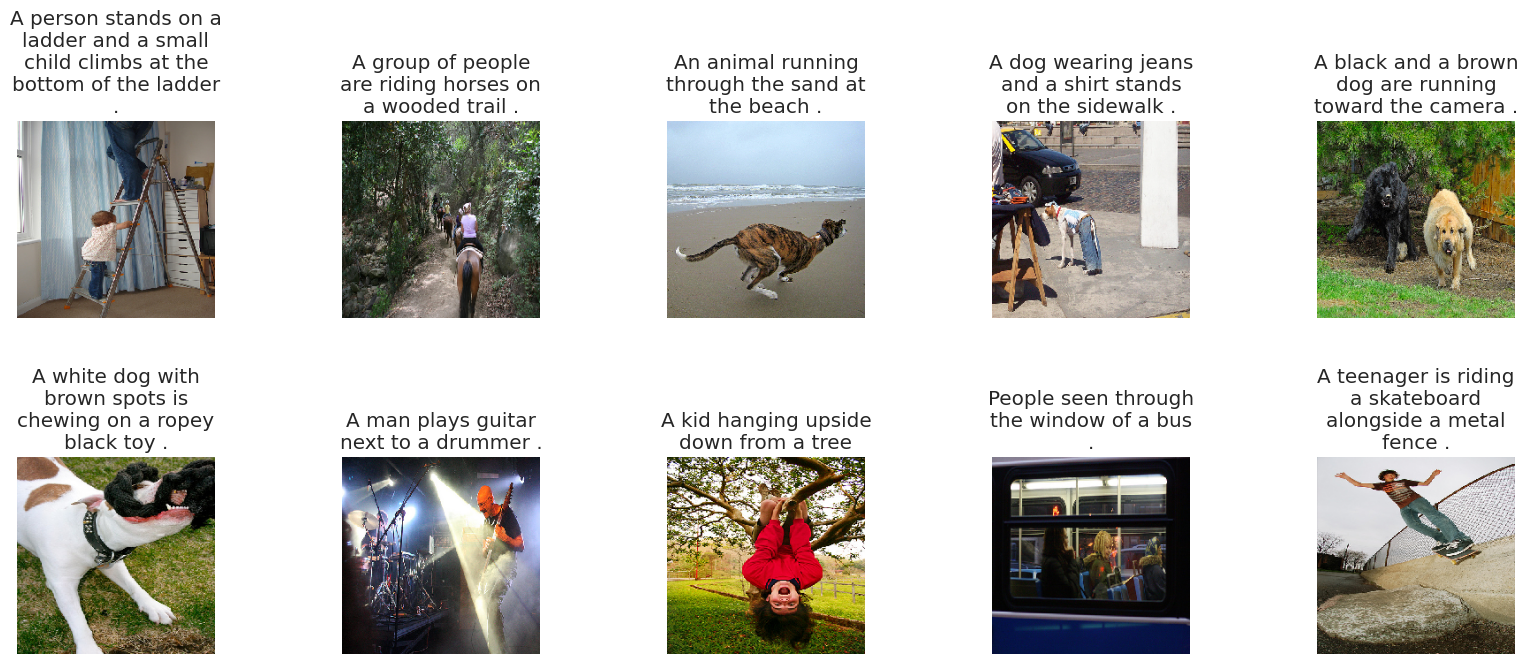

In [3]:
display_images(data.sample(10), path_image = image_path)

## Caption pre-processing

In [4]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Tokenization and Encoded Representation

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

## Train-test split

In [6]:
images = data['image'].unique().tolist()
split_index_val = round(0.80 * len(images))

train_images = images[ : split_index_val]
val_images = images[split_index_val : split_index_val + int(0.15 * split_index_val)]
test_images = images[split_index_val + int(0.15 * split_index_val) : ]

train = data[data['image'].isin(train_images)]
train.reset_index(inplace = True, drop = True)

test = data[data['image'].isin(val_images)]
test.reset_index(inplace = True, drop = True)

holdout = data[data['image'].isin(test_images)]
holdout.reset_index(inplace = True, drop = True)

## Image Feature Extraction

In [7]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[]


In [8]:
model = NASNetLarge() 
m = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 331
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = m.predict(img, verbose=0)
    features[image] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

## Modelling

In [9]:
input1 = Input(shape=(4032,))

img_features = Dense(2048, activation='relu')(input1)
img_features1 = Dense(1024, activation='relu')(img_features)
img_features1 = Dense(512, activation='relu')(img_features1)
img_features_reshaped = Reshape((1, 512), input_shape = (512,))(img_features1)

input2 = Input(shape=(max_length,))
sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped, sentence_features],axis=1)

sentence_features = LSTM(512)(merged)
x = Dropout(0.2)(sentence_features)
x = add([x, img_features1])

x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs = [input1, input2], outputs = output)
caption_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


In [10]:
from tensorflow.keras.utils import plot_model

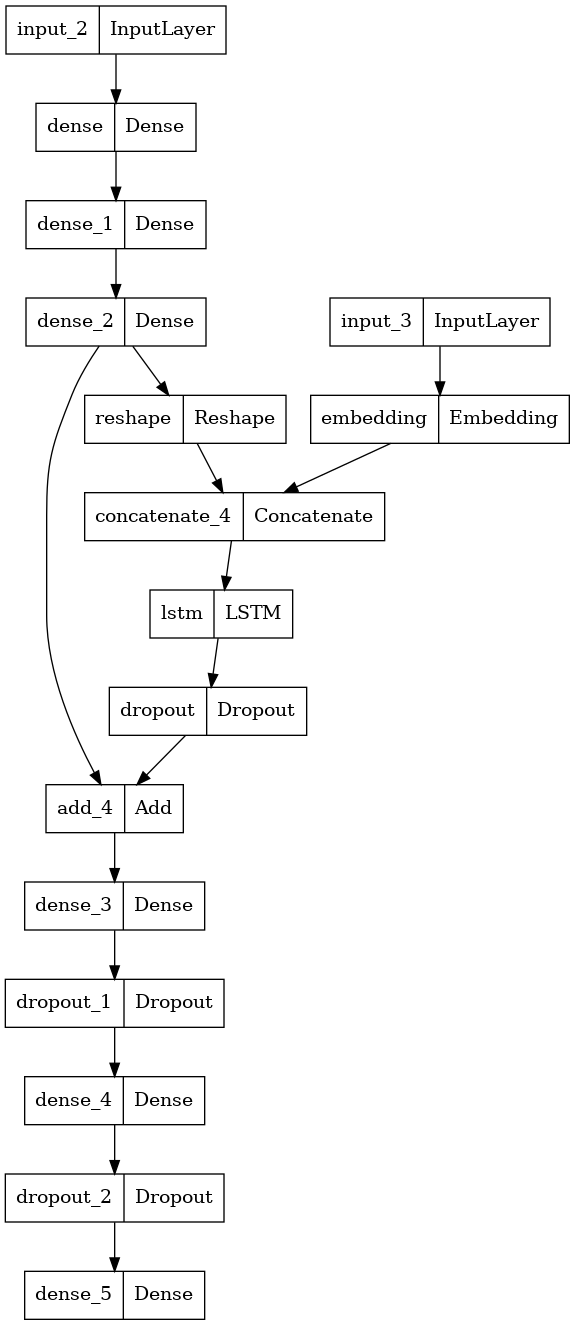

In [11]:
plot_model(caption_model)

## Model Modification
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

In [12]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4032)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         8259584     ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         2098176     ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 512)          524800      ['dense_1[0][0]']                
                                                                                            

In [13]:
train_generator = DataGenerator(df=train,X_col='image',y_col='caption',batch_size=32,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = DataGenerator(df=test,X_col='image',y_col='caption',batch_size=32,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [14]:
model_name = "NASNetModel_finalfinal_8k.h5"

checkpoint = ModelCheckpoint(model_name, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
earlystopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 6, verbose = 1, restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose = 1, factor = 0.2, min_lr = 0.00000001)

In [15]:
history = caption_model.fit(
        train_generator,
        epochs = 100,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/100
1011/1011 [==============================] - ETA: 0s - loss: 4.6814
Epoch 1: val_loss improved from inf to 4.02445, saving model to NASNetModel_finalfinal_8k.h5
1011/1011 [==============================] - 1347s 1s/step - loss: 4.6814 - val_loss: 4.0245 - lr: 0.0010
Epoch 2/100
1011/1011 [==============================] - ETA: 0s - loss: 3.6878
Epoch 2: val_loss improved from 4.02445 to 3.66954, saving model to NASNetModel_finalfinal_8k.h5
1011/1011 [==============================] - 384s 380ms/step - loss: 3.6878 - val_loss: 3.6695 - lr: 0.0010
Epoch 3/100
1011/1011 [==============================] - ETA: 0s - loss: 3.3181
Epoch 3: val_loss improved from 3.66954 to 3.55340, saving model to NASNetModel_finalfinal_8k.h5
1011/1011 [==============================] - 388s 383ms/step - loss: 3.3181 - val_loss: 3.5534 - lr: 0.0010
Epoch 4/100
1011/1011 [==============================] - ETA: 0s - loss: 3.0726
Epoch 4: val_loss improved from 3.55340 to 3.53070, saving model to NAS

## Inference
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## Learning Curve
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

3.50222
3.44626
3.37660

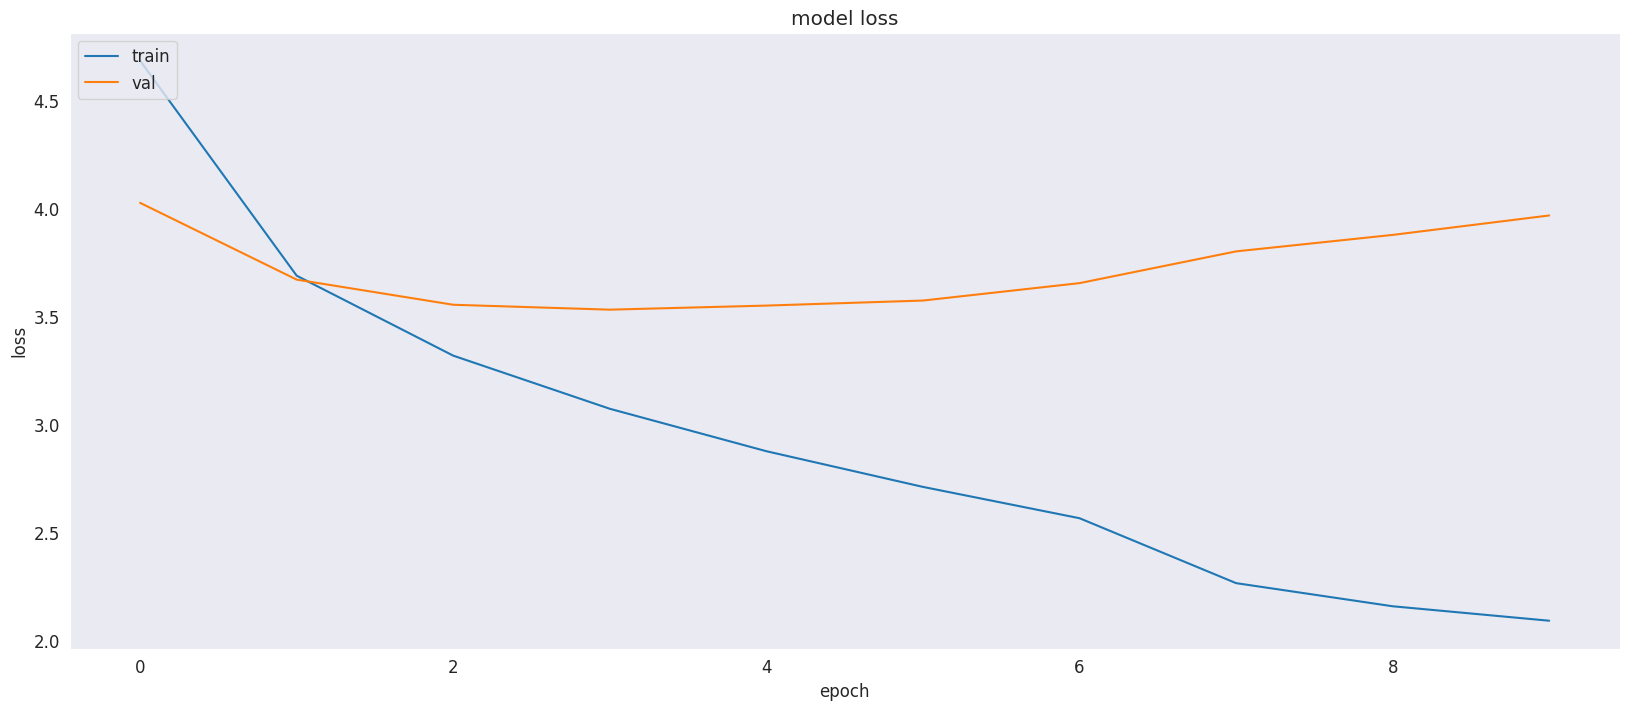

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Caption Generation Utility Functions
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

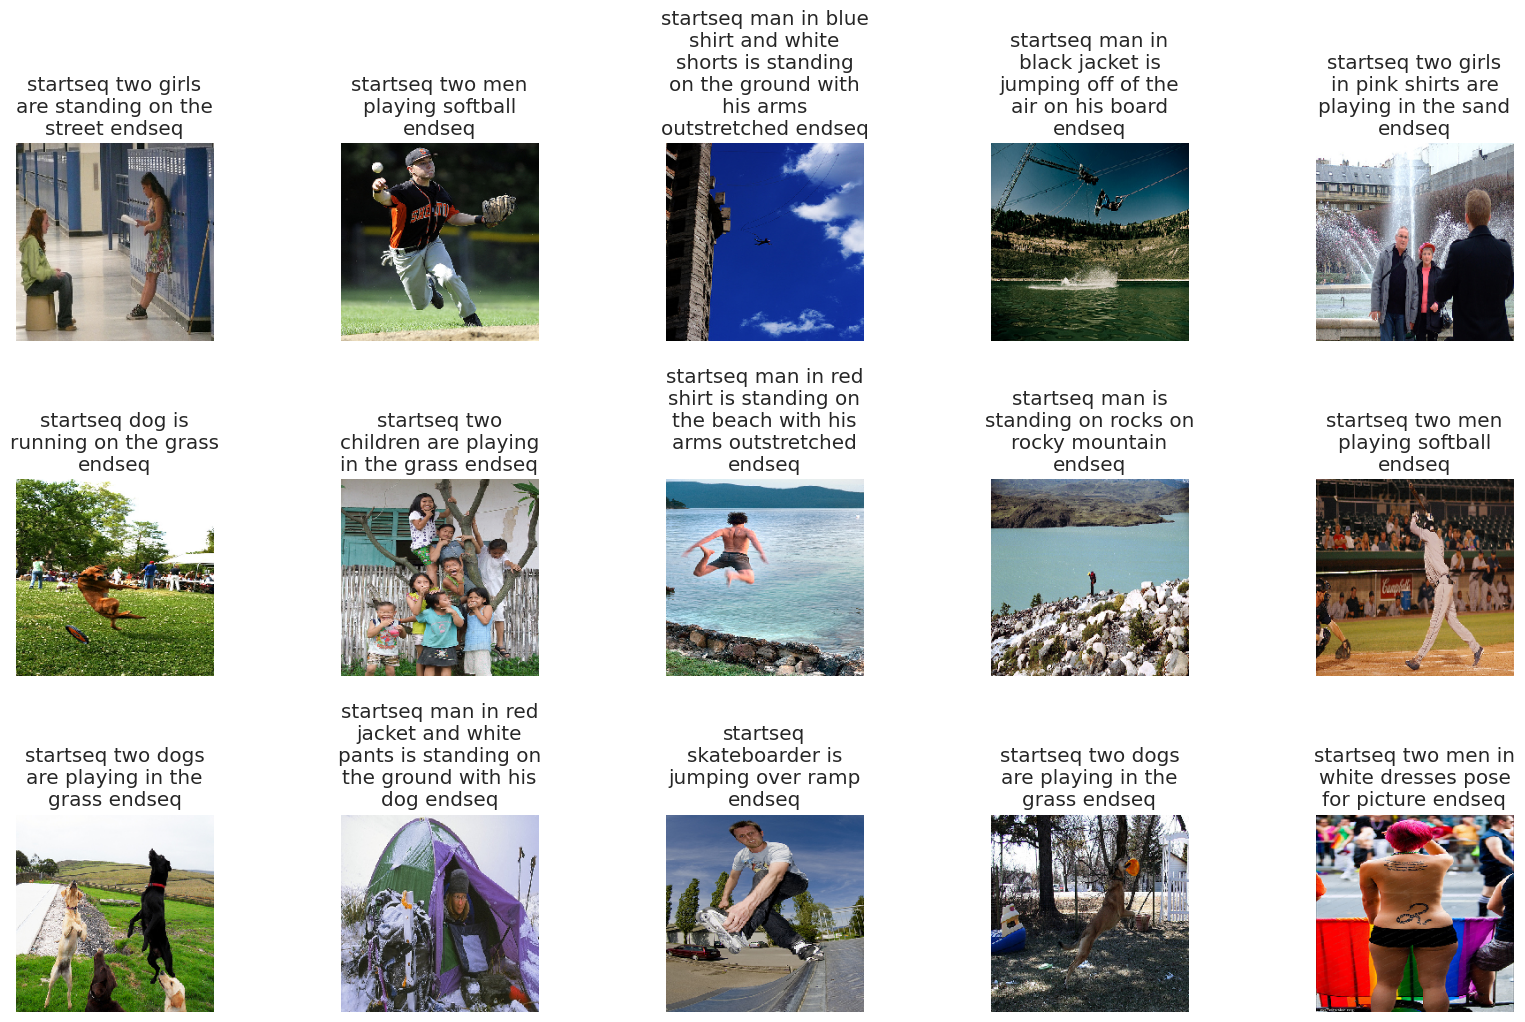

In [17]:
get_predictions(15, test, image_path, 
                    caption_model, tokenizer, max_length, 
                    features, verbosity = 0)